In [1]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchvision,torchmetrics,matplotlib

torch            : 1.10.1
pytorch_lightning: 1.6.0.dev0
torchvision      : 0.11.2
torchmetrics     : 0.6.2
matplotlib       : 3.3.4



In [2]:
%load_ext pycodestyle_magic
%flake8_on --ignore W291,W293,E703

<a href="https://pytorch.org"><img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.svg" width="90"/></a> &nbsp; &nbsp;&nbsp;&nbsp;<a href="https://www.pytorchlightning.ai"><img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.svg" width="150"/></a>

# Model Zoo -- MobileNet-v3 (Large) Trained on CIFAR-10

This notebook implements MobileNet-v3 [1] and applies it to the CIFRAR-10 dataset. MobileNet offers a great trade-off when it comes to predictive and computational performance.

### References

- [1] Howard, Andrew, Mark Sandler, Grace Chu, Liang-Chieh Chen, Bo Chen, Mingxing Tan, Weijun Wang et al. "[Searching for MobileNetV3](https://arxiv.org/abs/1905.02244)." In Proceedings of the IEEE/CVF International Conference on Computer Vision, pp. 1314-1324. 2019.

## General settings and hyperparameters

- Here, we specify some general hyperparameter values and general settings
- Note that for small datatsets, it is not necessary and better not to use multiple workers as it can sometimes cause issues with too many open files in PyTorch. So, if you have problems with the data loader later, try setting `NUM_WORKERS = 0` instead.

In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 150
LEARNING_RATE = 0.01
NUM_WORKERS = 4

## Implementing a Neural Network using PyTorch Lightning's `LightningModule`

- In this section, we set up the main model architecture using the `LightningModule` from PyTorch Lightning.
- When using PyTorch Lightning, we can start with defining our neural network  model in pure PyTorch, and then we use it in the `LightningModule` to get all the extra benefits that PyTorch Lightning provides.
- In this case, since Torchvision already offers a nice and efficient PyTorch implementation of MobileNet-v2, let's load it from the Torchvision hub:

In [4]:
import torch


pytorch_model = torch.hub.load(
    'pytorch/vision:v0.11.0',
    'mobilenet_v3_large',
    pretrained=False)

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.11.0


- Since the Torchvision model above was implemented for ImageNet, which has a different number of classes than CIFAR-10, we define our own output layer below:

In [5]:
pytorch_model.classifier[-1] = torch.nn.Linear(
        in_features=1280,  # as in the original output layer
        out_features=10)  # number of class labels in CIFAR-10)

- Next, we can define our `LightningModule` as a wrapper around our PyTorch model:

In [6]:
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    # Defining the forward method is only necessary 
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)
        
    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        
        # To account for Dropout behavior during evaluation
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## Setting up the dataset

- In this section, we are going to set up our dataset.

### Inspecting the dataset

In [7]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


train_dataset = datasets.CIFAR10(root='./data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', 
                                train=False,
                                transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         drop_last=False,
                         shuffle=False)

Files already downloaded and verified


In [8]:
from collections import Counter


train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

print('\nTraining label distribution:')
sorted(train_counter.items(), key=lambda pair: pair[0])


Training label distribution:


[(0, 4985),
 (1, 4989),
 (2, 4993),
 (3, 4993),
 (4, 4993),
 (5, 4995),
 (6, 4995),
 (7, 4993),
 (8, 4990),
 (9, 4994)]

In [9]:
test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print('\nTest label distribution:')
sorted(test_counter.items(), key=lambda pair: pair[0])


Test label distribution:


[(0, 1000),
 (1, 1000),
 (2, 1000),
 (3, 1000),
 (4, 1000),
 (5, 1000),
 (6, 1000),
 (7, 1000),
 (8, 1000),
 (9, 1000)]

### A quick visual check

In [10]:
%matplotlib inline

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

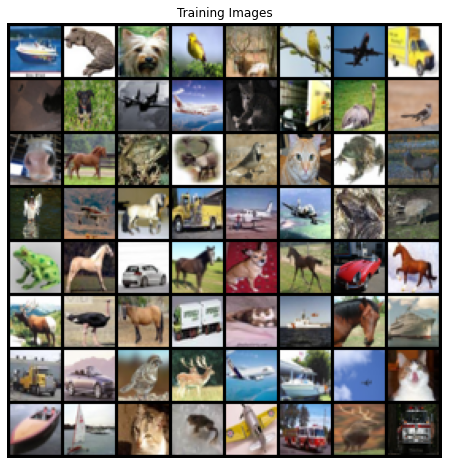

In [12]:
for images, labels in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

### Performance baseline

- Especially for imbalanced datasets, it's quite useful to compute a performance baseline.
- In classification contexts, a useful baseline is to compute the accuracy for a scenario where the model always predicts the majority class -- you want your model to be better than that!

In [13]:
majority_class = test_counter.most_common(1)[0]
majority_class

(3, 1000)

- (To be fair, the classes in the test set are perfectly evenly distributed, so the majority class is an arbitrary choice in this case)

In [14]:
baseline_acc = majority_class[1] / sum(test_counter.values())
print('Accuracy when always predicting the majority class:')
print(f'{baseline_acc:.2f} ({baseline_acc*100:.2f}%)')

Accuracy when always predicting the majority class:
0.10 (10.00%)


### Setting up a `DataModule`

- There are three main ways we can prepare the dataset for Lightning. We can
  1. make the dataset part of the model;
  2. set up the data loaders as usual and feed them to the fit method of a Lightning Trainer -- the Trainer is introduced in the next subsection;
  3. create a LightningDataModule.
- Here, we are going to use approach 3, which is the most organized approach. The `LightningDataModule` consists of several self-explanatory methods as we can see below:


In [15]:
import os

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision import transforms


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        
    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path,
                         download=True)

        # Note: Network trains about 2-3x faster if we don't
        # resize (keeping the orig. 32x32 res.)
        # However, the test set accuracy is approx 10% lower
        # on the original 32x32 resolution
        self.train_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((70, 70)),
            torchvision.transforms.RandomCrop((64, 64)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.test_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((70, 70)),        
            torchvision.transforms.CenterCrop((64, 64)),            
            torchvision.transforms.ToTensor(),                
            torchvision.transforms.Normalize(
                (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        return

    def setup(self, stage=None):
        train = datasets.CIFAR10(root=self.data_path, 
                                 train=True, 
                                 transform=self.train_transform,
                                 download=False)

        self.test = datasets.CIFAR10(root=self.data_path, 
                                     train=False, 
                                     transform=self.test_transform,
                                     download=False)

        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(dataset=self.train, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=True,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(dataset=self.valid, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(dataset=self.test, 
                                 batch_size=BATCH_SIZE, 
                                 drop_last=False,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS)
        return test_loader

- Note that the `prepare_data` method is usually used for steps that only need to be executed once, for example, downloading the dataset; the `setup` method defines the the dataset loading -- if you run your code in a distributed setting, this will be called on each node / GPU. 
- Next, lets initialize the `DataModule`; we use a random seed for reproducibility (so that the data set is shuffled the same way when we re-execute this code):

In [16]:
torch.manual_seed(1) 
data_module = DataModule(data_path='./data')

## Training the model using the PyTorch Lightning Trainer class

- Next, we initialize our model.
- Also, we define a call back so that we can obtain the model with the best validation set performance after training.
- PyTorch Lightning offers [many advanced logging services](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) like Weights & Biases. Here, we will keep things simple and use the `CSVLogger`:

In [17]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


lightning_model = LightningModel(
    pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='max', monitor="valid_acc")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="my-model")

- Now it's time to train our model:

In [18]:
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | model     | MobileNetV3 | 4.2 M 
1 | train_acc | Accuracy    | 0     
2 | valid_acc | Accuracy    | 0     
3 | test_acc  | Accuracy    | 0     
------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.859    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 57.12 min in total.


## Evaluating the model

- After training, let's plot our training ACC and validation ACC using pandas, which, in turn, uses matplotlib for plotting (you may want to consider a [more advanced logger](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) that does that for you):

<AxesSubplot:xlabel='Epoch', ylabel='ACC'>

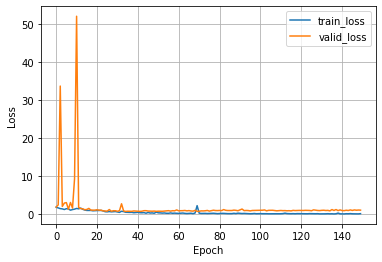

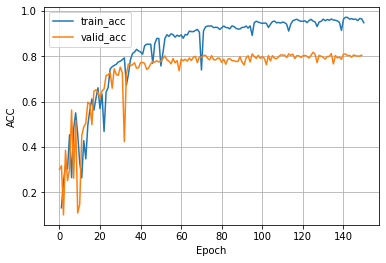

In [19]:
import pandas as pd


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='ACC')

- The `trainer` automatically saves the model with the best validation accuracy automatically for us, we which we can load from the checkpoint via the `ckpt_path='best'` argument; below we use the `trainer` instance to evaluate the best model on the test set:

In [20]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

Files already downloaded and verified


Restoring states from the checkpoint path at logs/my-model/version_51/checkpoints/epoch=125-step=44225.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/my-model/version_51/checkpoints/epoch=125-step=44225.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8198999762535095     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8198999762535095}]

## Predicting labels of new data

- You can use the `trainer.predict` method on a new `DataLoader` or `DataModule` to apply the model to new data.
- Alternatively, you can also manually load the best model from a checkpoint as shown below:

In [21]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs/my-model/version_51/checkpoints/epoch=125-step=44225.ckpt


In [22]:
lightning_model = LightningModel.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();

- Note that our PyTorch model, which is passed to the Lightning model requires input arguments. However, this is automatically being taken care of since we used `self.save_hyperparameters()` in our PyTorch model's `__init__` method.
- Now, below is an example applying the model manually. Here, pretend that the `test_dataloader` is a new data loader.

In [23]:
test_dataloader = data_module.test_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in test_dataloader:
    features, labels = batch
    
    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels = torch.cat(all_predicted_labels)
all_true_labels = torch.cat(all_true_labels)
all_predicted_labels[:5]

tensor([3, 8, 8, 0, 6])

Just as an internal check, if the model was loaded correctly, the test accuracy below should be identical to the test accuracy we saw earlier in the previous section.

In [24]:
test_acc = torch.mean((all_predicted_labels == all_true_labels).float())
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.8199 (81.99%)


## Inspecting Failure Cases

- In practice, it is often informative to look at failure cases like wrong predictions for particular training instances as it can give us some insights into the model behavior and dataset.
- Inspecting failure cases can sometimes reveal interesting patterns and even highlight dataset and labeling issues.

In [25]:
# Append the folder that contains the 
# helper_data.py, helper_plotting.py, and helper_evaluate.py
# files so we can import from them

import sys
sys.path.append('../pytorch_ipynb')

In [26]:
from helper_data import UnNormalize
from helper_plotting import show_examples

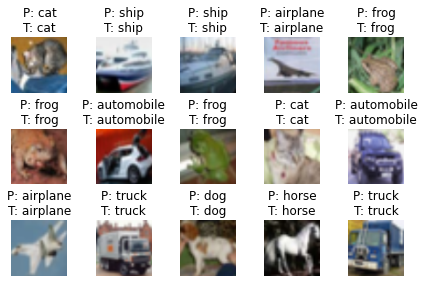

In [27]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

# We normalized each channel during training; here 
# we are reverting the normalization so that we 
# can plot them as images
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(
    model=lightning_model,
    data_loader=test_dataloader,
    unnormalizer=unnormalizer,
    class_dict=class_dict)

In [28]:
from torchmetrics import ConfusionMatrix


cmat = ConfusionMatrix(num_classes=len(class_dict))

for x, y in test_dataloader:
    pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()

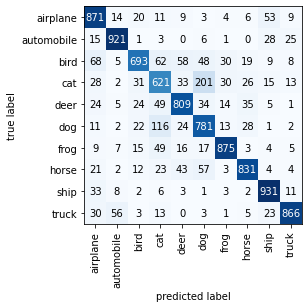

In [29]:
from helper_plotting import plot_confusion_matrix


plot_confusion_matrix(
    cmat_tensor.numpy(),
    class_names=class_dict.values())
plt.show()

## Single-image usage

In [30]:
%matplotlib inline

In [31]:
import matplotlib.pyplot as plt

- Assume we have a single image as shown below:

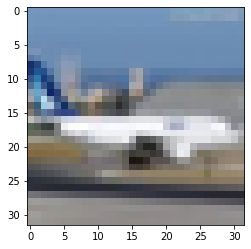

In [32]:
from PIL import Image


image = Image.open('data/cifar10_pngs/90_airplane.png')
plt.imshow(image, cmap='Greys')
plt.show()

- Note that we have to use the same image transformation that we used earlier in the `DataModule`. 
- While we didn't apply any image augmentation, we could use the `to_tensor` function from the torchvision library; however, as a general template that provides flexibility for more complex transformation chains, let's use the `Compose` class for this:

In [33]:
transform = data_module.train_transform

image_chw = transform(image)

- Note that `ToTensor` returns the image in the CHW format. CHW refers to the dimensions and stands for channel, height, and width.

In [34]:
print(image_chw.shape)

torch.Size([3, 64, 64])


- However, the PyTorch / PyTorch Lightning model expectes images in NCHW format, where N stands for the number of images (e.g., in a batch).
- We can add the additional channel dimension via `unsqueeze` as shown below:

In [35]:
image_nchw = image_chw.unsqueeze(0)
print(image_nchw.shape)

torch.Size([1, 3, 64, 64])


- Now that we have the image in the right format, we can feed it to our classifier:

In [36]:
with torch.no_grad():  # since we don't need to backprop
    logits = lightning_model(image_nchw)
    probas = torch.softmax(logits, axis=1)
    predicted_label = torch.argmax(probas)

In [37]:
int_to_str = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'}

In [38]:
print(f'Predicted label: {int_to_str[predicted_label.item()]}')
print(f'Class-membership probability {probas[0][predicted_label]*100:.2f}%')

Predicted label: airplane
Class-membership probability 100.00%
